In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chellaindu","key":"659f1503d814eb86abc3b32b07aae9ba"}'}

In [0]:
!pip install -q kaggle

In [0]:
import os
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 /root/.kaggle/kaggle.json
!mkdir santander
!cd santander

In [0]:
!kaggle competitions download -c santander-customer-transaction-prediction

 90% 110M/122M [00:00<00:00, 130MB/s] 
100% 122M/122M [00:00<00:00, 130MB/s]
  0% 0.00/463k [00:00<?, ?B/s]
100% 463k/463k [00:00<00:00, 61.3MB/s]
 87% 106M/122M [00:00<00:00, 127MB/s] 
100% 122M/122M [00:00<00:00, 138MB/s]


In [0]:
!mv sample_submission.csv.zip santander/
!mv train.csv.zip santander/
!mv test.csv.zip santander/

In [0]:
!mv santander/train.csv.zip santander/train.zip
!mv santander/test.csv.zip santander/test.zip

In [0]:
!unzip santander/train.zip -d santander/
!unzip santander/test.zip -d santander/

Archive:  santander/train.zip
  inflating: santander/train.csv     
Archive:  santander/test.zip
  inflating: santander/test.csv      


In [0]:
!rm santander/train.zip santander/test.zip santander/sample_submission.csv.zip

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, Binarizer, KernelCenterer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
import warnings
warnings.filterwarnings('ignore')

In [0]:
train = pd.read_csv("santander/train.csv")
test = pd.read_csv("santander/test.csv")

train.columns

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)

In [0]:
train.head(5)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [0]:
train.shape, test.shape

((200000, 202), (200000, 201))

In [0]:
## missing data

(train.isnull().values.any(), test.isnull().values.any())

## no missing data

(False, False)

In [0]:
## class imbalance: 2 classes : 1 and 0
train['target'].value_counts(normalize = True)

0    0.89951
1    0.10049
Name: target, dtype: float64

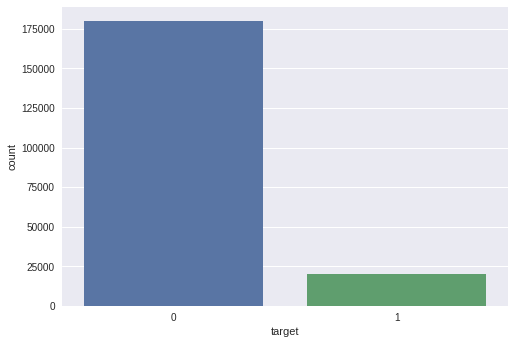

In [0]:
sns.countplot(train['target'])

In [0]:
## Scaling and Standardization
sc = StandardScaler()

train_std = sc.fit_transform(train[train.columns.difference(['ID_code', 'target'])])
test_std = sc.transform(test[test.columns.difference(['ID_code'])])

In [0]:
train_std = pd.DataFrame(train_std)
test_std = pd.DataFrame(test_std)

In [0]:
train_std['target'] = train['target']
train_std['ID_code'] = train['ID_code']
test_std['ID_code'] = test['ID_code']

In [0]:
## Resampling: 

train_pos = train_std[train_std['target'] == 1]
train_neg = train_std[train_std['target'] == 0]

train_std['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

In [0]:
## upsample minority class: https://elitedatascience.com/imbalanced-classes
## minority class - positive class

train_pos_upsampled = resample(train_pos, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(train_neg),    # to match majority class
                                 random_state=42) 
 
# Combine majority class with upsampled minority class
train_upsampled = pd.concat([train_neg, train_pos_upsampled])

train_upsampled['target'].value_counts()


1    179902
0    179902
Name: target, dtype: int64

In [0]:
target = train_upsampled['target']
train_upsampled = train_upsampled.drop(['ID_code', 'target'], axis = 1)

In [0]:
X_train,X_test,y_train,y_test=train_test_split(train_upsampled,target,test_size=0.2,random_state=0)

**Logistic Regression**

In [0]:
logist_reg = LogisticRegression()
logist_reg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
#prediction
y_pred=logist_reg.predict(X_test)

In [0]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[28157,  7974],
       [ 7825, 28005]])

In [0]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7804505218104251
Precision: 0.7783707162511465
Recall: 0.7816075914038515


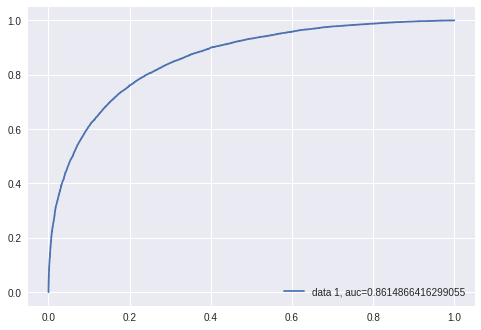

In [0]:
#ROC
y_pred_proba = logist_reg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


In [0]:
test_std.columns.difference(['ID_code'])

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       190, 191, 192, 193, 194, 195, 196, 197, 198, 199],
      dtype='object', length=200)

In [0]:
test_1 = test_std.drop(['ID_code'], axis = 1)
y_pred_test = logist_reg.predict(test_1)


'''submission = pd.DataFrame({'ID_code':test_std.ID_code,'target':y_pred_test})
submission.to_csv('santander/submission.csv', index=False)'''

**Naive Bayes**

In [0]:
## Naive Bayes:

gnb = GaussianNB()
gnb.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [0]:
y_test_pred_gnb = gnb.predict(test_1)

In [0]:
submission = pd.DataFrame({'ID_code':test_std.ID_code,'target':y_test_pred_gnb})
submission.to_csv('santander/submission.csv', index=False)

**Ensemble: Logistic Regression + Gaussian Naive Bayes + AdaBoost**

In [0]:
logist_reg = LogisticRegression()
gnb = GaussianNB()
ada = AdaBoostClassifier(n_estimators=50, random_state=0)

estimators = []
estimators.append(('logistic', logist_reg))
estimators.append(('GaussianNB', gnb))
estimators.append(('AdaBoost', ada))

ensemble = VotingClassifier(estimators)

In [0]:
ensemble.fit(train_upsampled,target)

VotingClassifier(estimators=[('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('GaussianNB', GaussianNB(priors=None, var_smoothing=1e-09)), ('AdaBoost', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=0))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [0]:
y_test_pred_en = ensemble.predict(test_1)

In [0]:
submission = pd.DataFrame({'ID_code':test_std.ID_code,'target':y_test_pred_en})
submission.to_csv('santander/submission.csv', index=False)

**Ensemble: XGBoost + Light GBM **

In [0]:
import lightgbm
from xgboost import XGBClassifier


In [0]:
## XGBoost

xgbclf = XGBClassifier(objective="binary:logistic", eval_metric='auc', max_depth=4, gamma=5, min_child_weight=50, reg_lambda=1, reg_alpha=0, 
                       booster='gbtree', random_state=0, silent=None, n_estimators=200)

xgbclf.fit(train_upsampled, target, verbose = True)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=5, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=50, missing=None,
       n_estimators=200, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1)

In [0]:
y_pred_xgb = xgbclf.predict(test_1)

In [0]:
submission = pd.DataFrame({'ID_code':test_std.ID_code,'target':y_pred_xgb})
submission.to_csv('santander/submission.csv', index=False)

In [0]:
## LightGBM
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.041,
    'learning_rate': 0.0083,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1
}

In [0]:
x, x_val, y, y_val = train_test_split(train_upsampled, target, test_size=0.2, random_state=0)

train_data = lightgbm.Dataset(x, label=y)
val_data = lightgbm.Dataset(x_val, label=y_val)

clf = lightgbm.train(param, train_data, 10000, early_stopping_rounds = 2000, valid_sets = [train_data, val_data], verbose_eval=5000)

y_pred_lgbm = clf.predict(test_1, num_iteration=clf.best_iteration)

Training until validation scores don't improve for 2000 rounds.
[5000]	training's auc: 0.92865	valid_1's auc: 0.922914
[10000]	training's auc: 0.947005	valid_1's auc: 0.938366
Did not meet early stopping. Best iteration is:
[10000]	training's auc: 0.947005	valid_1's auc: 0.938366


In [0]:
submission = pd.DataFrame({'ID_code':test_std.ID_code,'target':y_pred_lgbm})
submission.to_csv('santander/submission.csv', index=False)

In [0]:
## Stacking Classifier: GNB, XGBoost, LightGBM, KNN : Meta: Logistic Regression

from sklearn.neighbors import KNeighborsClassifier
from mlxtend.classifier import StackingCVClassifier

RANDOM_SEED = 0

np.random.seed(RANDOM_SEED)

clf1 = KNeighborsClassifier(n_neighbors=3)
clf2 = XGBClassifier(objective="binary:logistic", eval_metric='auc', max_depth=4, gamma=5, min_child_weight=50, reg_lambda=1, reg_alpha=0, 
                       booster='gbtree', random_state=0, silent=None, n_estimators=200)
clf3 = GaussianNB()
#clf4 = lightgbm.train(param, train_data, 10000, early_stopping_rounds = 2000, valid_sets = [train_data, val_data], verbose_eval=5000)

lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                            use_probas=True,
                            meta_classifier=lr)



In [0]:
from sklearn import model_selection
print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'XGBoost', 
                       'Gaussian Naive Bayes',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, train_upsampled, target, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))
    
sclf.fit(train_upsampled, target)

y_pred_stack = sclf.predict(test_1)



3-fold cross validation:



In [0]:
submission = pd.DataFrame({'ID_code':test_std.ID_code,'target':y_pred_stack})
submission.to_csv('santander/submission.csv', index=False)